# Подключение нобходимых библиотек.

In [1]:
# Main imports
import os
import numpy as np
import pandas as pd

# Label encoder
import pickle
from sklearn.preprocessing import LabelEncoder

# Torch
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.metrics import f1_score

# Images and graphics
from matplotlib import colors, pyplot as plt
%matplotlib inline

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path


# Создание класса датасета.

Определим основные константы и параметры.

In [2]:
DATA_MODES = ['train', 'val', 'test']

RESCALE_SIZE = 256

DEVICE = torch.device("cuda")

TEST_DIR = 'dataset/test'
TRAIN_DIR = 'dataset/data'

In [3]:
class AvitoDataset(Dataset):
    def __init__(self, df: pd.DataFrame, mode):
        super().__init__()

        self.files = df['id']
        self.mode = mode
        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError
        
        
        self.labels = df['target']
        self.len = len(self.labels)

        self.label_encoder = LabelEncoder()

        if self.mode == 'train':
            # Обучаем Label Encoder
            self.label_encoder.fit(self.labels)

            # Сохраняем обученый енкодер
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

            # Запомним количество классов на будущее
            self.class_counts = self.labels.value_counts().sort_index()
        else:
            # Загружаем обученный Label Encoder
            if os.path.exists('label_encoder.pkl'):
                with open('label_encoder.pkl', 'rb') as le_dump_file:
                    self.label_encoder = pickle.load(le_dump_file)
            else:
                print('Label encoder file does not exist. Create train dataset first, to train label encoder.')
                raise FileNotFoundError
    
    def get_class_weights(self, min_size):
        """Возвращает веса для каждого класса"""
        if self.mode != 'train':
            raise ValueError("Weighted sampling только для train!")
        
        class_weights = 1. / torch.tensor(self.class_counts.values, dtype=torch.float)
        max_weight = 1 / min_size

        class_weights = torch.clamp(class_weights, max=max_weight)

        return class_weights
    
    def get_sample_weights(self, min_size):
        """Для каждого элемента в датасете возвратит его вес"""

        class_weights = self.get_class_weights(min_size)

        sample_weights = [class_weights[self.label_encoder.transform([label])[0]] 
                        for label in self.labels]
        
        return sample_weights
    
    def load_sample(self, file_id):
        # Путь до файла
        file_dir = TEST_DIR if self.mode == 'test' else TRAIN_DIR
        file = f'{file_dir}/{file_id}.jpg'

        image = Image.open(file)
        image.load()
        return image
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        x = self.load_sample(self.files[index])

        if self.mode == 'train':
            # Определяем класс изображения
            label = self.labels[index]
            class_count = self.class_counts[label]

            # Базовые аугментации для всех классов
            transform_list = [
                transforms.RandomResizedCrop(RESCALE_SIZE, scale=(0.8, 1.0)),
            ]
             # Теперь определяем, насколько редкий класс
            if class_count < 50: # для редких классов
                transform_list.extend([
                    transforms.RandomAffine(degrees=25, translate=(0.2, 0.2)),
                    transforms.RandomPerspective(distortion_scale=0.5, p=0.7),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                    transforms.RandomHorizontalFlip(p=0.8),
                ])

            elif 50 <= class_count < 500: # Для менее редких классов
                transform_list.extend([
                transforms.RandomHorizontalFlip(0.5),
                transforms.RandomRotation(15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                ])
            else: # Для наиболее значимых классов
                transform_list.extend([
                transforms.RandomHorizontalFlip(p=0.3),
                ])

            transform_list.extend([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

            transform = transforms.Compose(transform_list)

            # Применяем наши преобразования
            x = transform(x)

        else:
            # Определяем стандартные преобразования
            basic_transform = transforms.Compose([
                transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            x = basic_transform(x)

        
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

Разделение выборки на train и val + создадим объекты датасетов.

In [4]:
df = pd.read_csv(f"dataset/data.csv")
train_val_files = df
train_val_labels = df['target']

# Делим выборку на train и val
from sklearn.model_selection import train_test_split
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

train_files = train_files.reset_index(drop=True)
val_files = val_files.reset_index(drop=True)

# Создадим объекты датасетов.
train_dataset = AvitoDataset(train_files, mode='train')
val_dataset = AvitoDataset(val_files, mode='val')

# Сравним размеры чтобы избежать ошибок.
print(f"Original len: train = {len(train_files)}, val = {len(val_files)}")
print(f"Dataset len: train = {train_dataset.len}, val = {val_dataset.len}")

Original len: train = 21227, val = 7076
Dataset len: train = 21227, val = 7076


## Рассмотрим распределение классов внутри оригинального датасета.

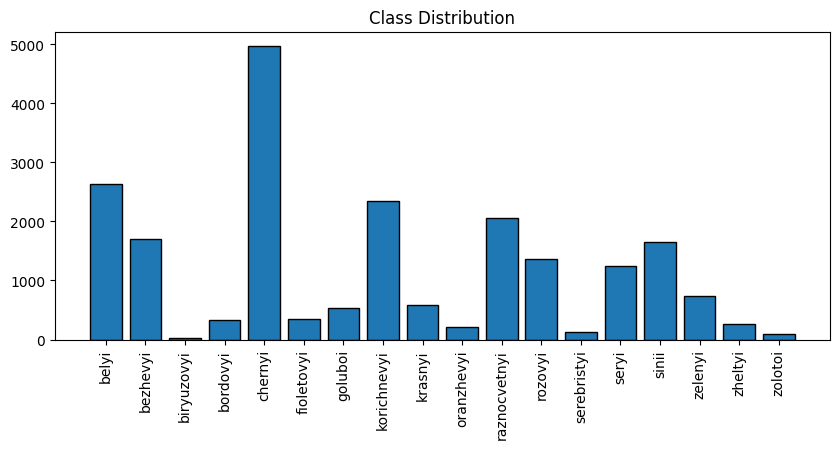

In [5]:
plt.figure(figsize=(10,4))
plt.bar(train_dataset.class_counts.index, train_dataset.class_counts.values, edgecolor='black')
plt.xticks(rotation=90)
plt.title("Class Distribution")
plt.show()

Видим, что классы несбалансированы.

## Семплирование весов (только для train)

In [6]:
# Сделаем weight sampleing
from torch.utils.data import WeightedRandomSampler

MIN_SIZE = 150 # минимальный размер примера

# Получаем веса для каждого примера
sample_weights = train_dataset.get_sample_weights(MIN_SIZE)

# Получаем веса классов
class_weights = train_dataset.get_class_weights(MIN_SIZE)

# Создаём семплер
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # Сколько примеров выбирать за эпоху
    replacement=True  # Обязательно для миноритарных классов!
)

## Создание DataLoaders

In [7]:
# Создадим Dataloaders

train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

## Посмотрим на распределение весов теперь.

In [8]:
# # Получаем список label_ids, которые будут сэмплиться
# sampled_label_ids = [train_dataset[index][1] for index in sampler]

# # Преобразуем в имена классов
# sampled_labels = train_dataset.label_encoder.inverse_transform(sampled_label_ids)

# # Рисуем гистограмму
# plt.figure(figsize=(12, 4))
# plt.hist(sampled_labels, bins=len(train_dataset.class_counts), edgecolor='black')
# plt.xticks(rotation=90)
# plt.title("Sampled Class Distribution (after WeightedRandomSampler)")
# plt.tight_layout()
# plt.show()


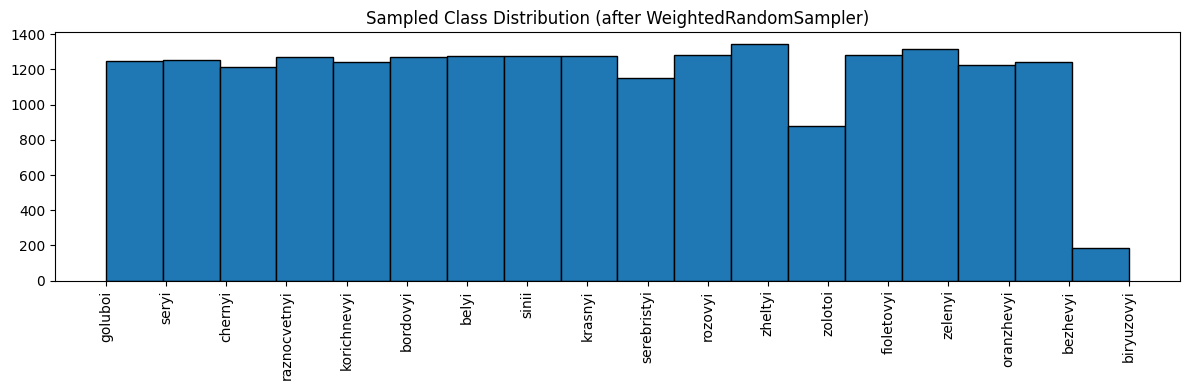


## Теперь рассмотрим получившиеся изображения в датасете.

In [9]:
show_val_dataset = DataLoader(val_dataset, batch_size=16)
show_train_dataset = DataLoader(train_dataset, batch_size=32, sampler=sampler)

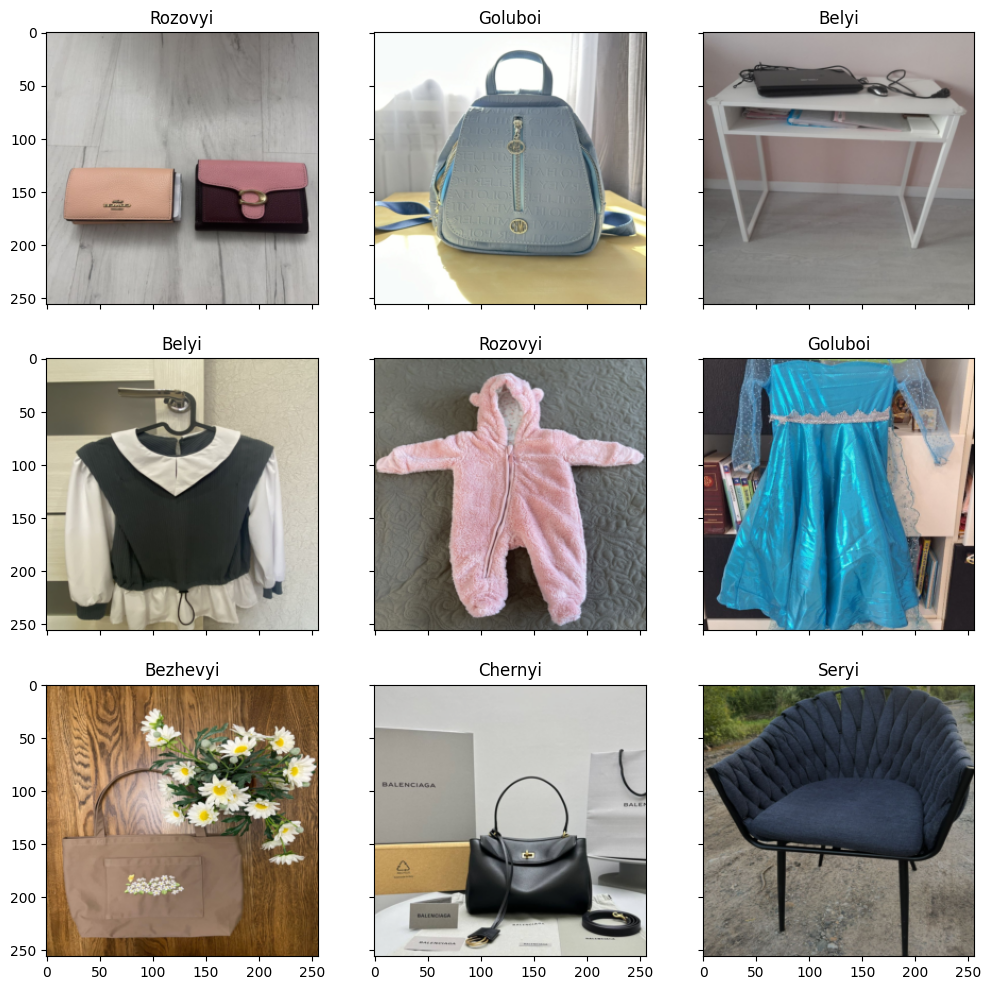

In [10]:
from matplotlib import pyplot as plt

def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = show_train_dataset.dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), show_train_dataset.dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)

# Функции для обучения


In [11]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    all_preds = []
    all_labels = []

    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outp = model(inputs)
        loss = criterion(outp, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outp, 1)

        running_loss += loss.item() * inputs.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        running_corrects += torch.sum(preds == labels.data) 
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    train_f1 = f1_score(all_labels, all_preds, average='macro')
    return train_loss, train_acc, train_f1

In [12]:
def eval_epoch(model, val_loader, criterion):
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    all_preds = []
    all_labels = []


    for inputs, labels in val_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            processed_size += inputs.size(0)
            
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    val_f1 = f1_score(all_labels, all_preds, average='macro')

    return val_loss, val_acc, val_f1

In [13]:
from tqdm import tqdm
import numpy as np
from torch.utils.data import DataLoader
import os

def train(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    epochs: int = 10,
    device: str = DEVICE
) -> tuple:
    """
    Возвращает:
        history: словарь с историей метрик
        model: обученная модель
    """
    history = {
        'train_loss': [],
        'train_acc': [],
        'train_f1': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': []
    }
    
    model = model.to(device)
    
    # Настройка цветов для tqdm
    COLORS = {
        'train': '\033[34m',  # синий
        'val': '\033[32m',    # зелёный
        'bold': '\033[1m',
        'end': '\033[0m'
    }
    os.makedirs("checkpoints", exist_ok=True)
    best_f1 = 0.0
    
    
    epoch_pbar = tqdm(range(epochs), desc='Epochs', position=0, leave=True)
    
    for epoch in epoch_pbar:
        # Обучение
        train_loss, train_acc, train_f1 = fit_epoch(model, train_loader, criterion, optimizer)
        # Валидация
        val_loss, val_acc, val_f1 = eval_epoch(model, val_loader, criterion)
        
        # Сохраняем метрики
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        

        # Сохраняем модель если улучшился F1 на валидации
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, os.path.join("checkpoints", 'best_model.pt'))
            
            tqdm.write(f"Val F1: {val_f1:.4f} (saved)")
        
        # Выводим метрики.
        tqdm.write(
            f"Epoch {epoch + 1}/{epochs} | "
            f"{COLORS['bold']}Train{COLORS['end']}: "
            f"loss {COLORS['train']}{train_loss:.4f}{COLORS['end']} "
            f"acc {train_acc:.4f} "
            f"f1 {train_f1:.4f} | "
            f"{COLORS['bold']}Val{COLORS['end']}: "
            f"loss {COLORS['val']}{val_loss:.4f}{COLORS['end']} "
            f"acc {val_acc:.4f} "
            f"f1 {val_f1:.4f}"
        )
    
    return history, model

In [14]:
def predict(model, test_loader):
    """
    Функция выполняет предсказание классов для тестового набора данных с использованием обученной модели.

    return: numpy.ndarray
        Массив вероятностей предсказанных классов для каждого примера в тестовом наборе.
        Размерность массива будет (N, C), где N - количество примеров, а C - количество классов.
    """

    with torch.no_grad():
        logits = []
        for inputs in test_loader:
            print(type(inputs[0]))
            if type(inputs) in (list, tuple):
                inputs = inputs[0]
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [15]:
import time
def inference_model(model, loader):
    model.eval()

    running_corrects = 0
    processed_size = 0

    all_preds = []
    all_labels = []
    all_times = []

    start_time = time.time()

    for inputs, labels in loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        with torch.no_grad():
            outputs = model(inputs)
            preds = torch.argmax(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_times.append(time.time() - start_time)
            processed_size += inputs.size(0)
            

    inference_time_sec = time.time() - start_time
    med_time = np.median(all_times)

    acc = running_corrects.double() / processed_size
    f1 = f1_score(all_labels, all_preds, average='macro')

    return acc, f1, inference_time_sec, med_time

# Бейзлайн

In [16]:
import torch.nn.functional as F

Создадим небольшую модель и обучим её.

In [17]:
class Baseline(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(3456, 2048),
            nn.BatchNorm1d(2048),
            nn.ELU(),
        )

        self.out = nn.Linear(2048, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        
        #print(x.shape)

        x = self.fc1(x)
        logits = self.out(x)
        return logits

In [18]:
# Создадим класс модели и посмотрим на ее вид.
n_classes = len(np.unique(train_val_labels))
base_model = Baseline(n_classes).to(DEVICE)
print(f"we will classify :{n_classes}")

# вид нашей модели
print(base_model)

we will classify :18
Baseline(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [19]:
# Подсчитаем кол-во параметров и убедимся в правильности нейросети.
from torchsummary import summary

#test_input = torch.randn(2, 3, 512, 512)
#output = base_model(test_input.cuda)

summary(base_model.cuda(), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 254, 254]             224
       BatchNorm2d-2          [-1, 8, 254, 254]              16
              ReLU-3          [-1, 8, 254, 254]               0
         MaxPool2d-4          [-1, 8, 127, 127]               0
            Conv2d-5         [-1, 16, 125, 125]           1,168
       BatchNorm2d-6         [-1, 16, 125, 125]              32
              ReLU-7         [-1, 16, 125, 125]               0
         MaxPool2d-8           [-1, 16, 62, 62]               0
            Conv2d-9           [-1, 32, 60, 60]           4,640
      BatchNorm2d-10           [-1, 32, 60, 60]              64
             ReLU-11           [-1, 32, 60, 60]               0
        MaxPool2d-12           [-1, 32, 30, 30]               0
           Conv2d-13           [-1, 64, 28, 28]          18,496
      BatchNorm2d-14           [-1, 64,

In [20]:
test_input = torch.randn(2, 3, 256, 256).to(DEVICE)

# Проверяем размерности
output = base_model(test_input)

In [21]:
#optimizer = torch.optim.Adam(base_model.parameters(), lr=3e-4)
#criterion = nn.CrossEntropyLoss(weight=class_weights.to(DEVICE))

In [22]:
#history, model = train(train_loader, val_loader, base_model, optimizer, criterion, epochs=10)

Загрузим лучшую получившуюся модель

In [23]:
# base_model = Baseline(n_classes).to(DEVICE)

# checkpoint = torch.load("checkpoints/best_model.pt", map_location=DEVICE)
# base_model.load_state_dict(checkpoint["model_state_dict"])
# base_model.eval()

Проверим работу нашей модели

In [24]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs


def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [25]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [26]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

def print_predictions(dataset, model):
    fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                            sharey=True, sharex=True)

    for fig_x in ax.flatten():
        random_characters = int(np.random.uniform(0,1000))
        im_val, label = dataset[random_characters]
        img_label = " ".join(map(lambda x: x.capitalize(),\
                    dataset.label_encoder.inverse_transform([label])[0].split('_')))


        imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)

        actual_text = "Actual : {}".format(img_label)

        fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
        font0 = FontProperties()
        font = font0.copy()
        font.set_family("fantasy")
        prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
        predicted_proba = np.max(prob_pred)*100
        y_pred = np.argmax(prob_pred)

        predicted_label = label_encoder.classes_[y_pred]
        predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
        predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

        fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                        verticalalignment='top',fontsize=8, color='black',fontweight='bold')

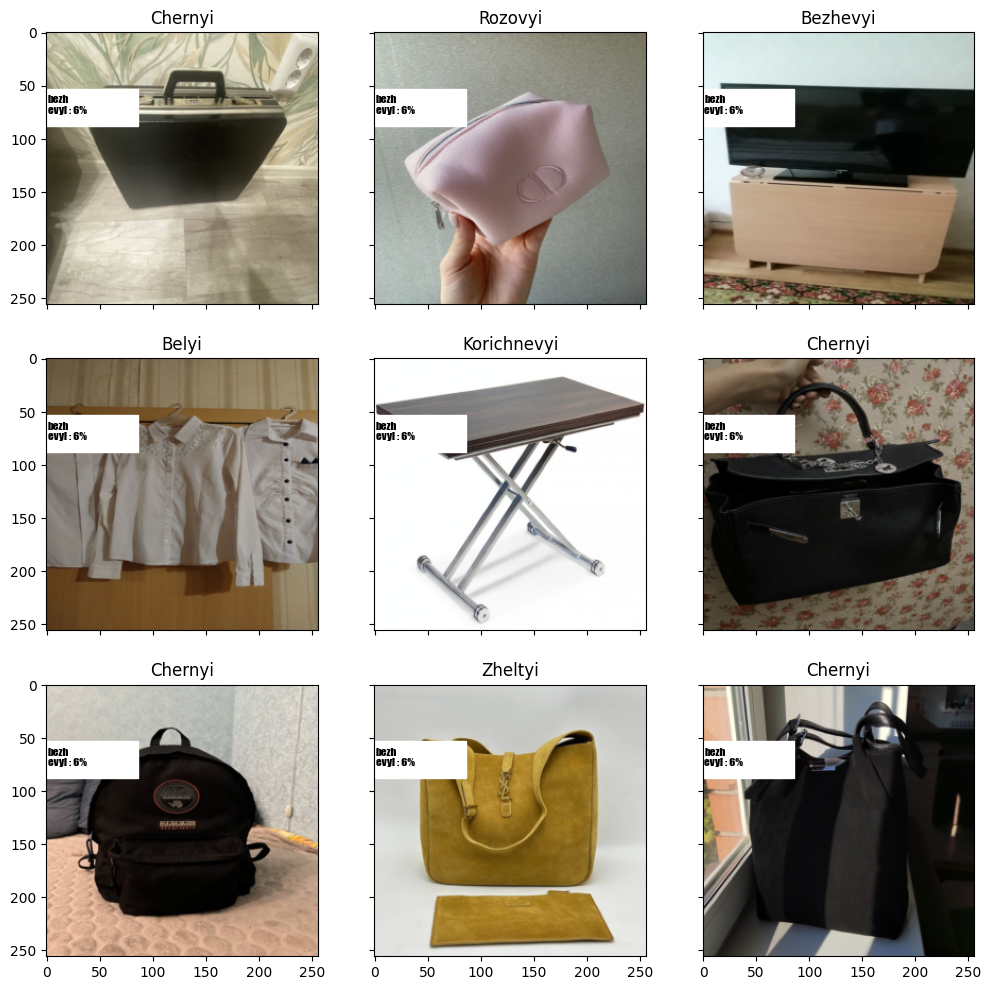

In [27]:
print_predictions(val_dataset, base_model)

# Воспользуемся предобученной моделью ResNet18

In [28]:
import torchvision.models as models
model_resnet = models.resnet18(pretrained=True)

c:\Users\vds\Work\Programming Stuff\hack\avito2\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vds\Work\Programming Stuff\hack\avito2\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
# Посмотрим на структуру модели
model_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
class fc_layers(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.out = nn.Linear(256, 18)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        logits = self.out(x)
        return logits
    
model_resnet.fc = fc_layers()

Разморозим веса модели и обучим 5 эпох.

In [31]:
for param in model_resnet.parameters():
    param.requires_grad = True

In [32]:
#optimizer = torch.optim.Adam(model_resnet.parameters(), lr=3e-4)
#criterion = nn.CrossEntropyLoss()

## Обучим модель.

In [33]:
#history, last_trained_model = train(train_loader, val_loader, model_resnet, optimizer, criterion, epochs=5)

In [34]:
def get_last_resnetmodel_18():
    model_resnet = models.resnet18(pretrained=False).to(DEVICE)

    model_resnet.fc = fc_layers()
    model_resnet = model_resnet.to(DEVICE)

    checkpoint = torch.load("checkpoints/best_model.pt", map_location=DEVICE)
    model_resnet.load_state_dict(checkpoint["model_state_dict"])
    return model_resnet

In [35]:
resnet_model = get_last_resnetmodel_18()

c:\Users\vds\Work\Programming Stuff\hack\avito2\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [36]:
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [37]:
for param in resnet_model.parameters():
    param.requires_grad = False

resnet_model.layer4.requires_grad_(True)
resnet_model.fc.requires_grad_(True)


fc_layers(
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (out): Linear(in_features=256, out_features=18, bias=True)
)

## Обучим 5 эпох 

In [38]:
#optimizer = torch.optim.Adam(resnet_model.parameters(), lr=3e-4)
#criterion = nn.CrossEntropyLoss()

In [39]:
#history, last_trained_model = train(train_loader, val_loader, resnet_model, optimizer, criterion, epochs=5)

## Можно заметить, что точность весьма маленькая. Давайте узнаем отдельно точность модели по каждой категории.

In [40]:
last_model = get_last_resnetmodel_18()

In [41]:
val_files['category'].unique()

array(['столы', 'одежда для девочек', 'сумки', 'стулья'], dtype=object)

In [42]:
# создадим словарь отдельно по категориям
dataset_categories = {}
for category in val_files['category'].unique():
    cat_files =  val_files[val_files['category'] == category].reset_index(drop=True)
    dataset_categories[category] = cat_files

In [43]:
for category, files in dataset_categories.items():
    # создаем датасет
    cat_dataset = AvitoDataset(files, "val")
    # создаем dataloader
    cat_dataloader = DataLoader(cat_dataset, 64, shuffle=False)

    # выполняем инференс модели
    acc, f1, all_time, med_time = inference_model(last_model, cat_dataloader)
    print(f'{category}:\n'
          f'Accuracy {acc:.4f}\n'
          f'F1 score {f1:.4f}\n'
          f'Inference Time {all_time:.3f}\n'
          f'Medium time for 1 image {med_time/64:.3f}\n')

столы:
Accuracy 0.7930
F1 score 0.5910
Inference Time 15.187
Medium time for 1 image 0.132

одежда для девочек:
Accuracy 0.8305
F1 score 0.7383
Inference Time 35.885
Medium time for 1 image 0.291

сумки:
Accuracy 0.8019
F1 score 0.6636
Inference Time 62.995
Medium time for 1 image 0.482

стулья:
Accuracy 0.8187
F1 score 0.6359
Inference Time 6.639
Medium time for 1 image 0.064



# Объеденим категории и цвета
4*18=72 класса

In [44]:
train_val_files = train_val_files.replace({'сумки': 'bags', 'одежда для девочек': "girls_wear", 'столы': "tabels", 'стулья': 'chairs'})
train_val_files['target'] = train_val_files['category'] + "_" + train_val_files['target']
train_val_files.drop(['category'], axis=1)

,id,target
0,11624739720,bags_zelenyi
1,11967354953,bags_chernyi
2,19026830493,bags_belyi
3,23088722867,bags_chernyi
4,23546690270,tabels_belyi
...,...,...
28298,37599243150,bags_bezhevyi
28299,37599243178,girls_wear_raznocvetnyi
28300,37599258032,bags_bezhevyi
28301,37599262080,girls_wear_bezhevyi


# Посмотрим на распределение классов теперь.

<Axes: xlabel='target'>

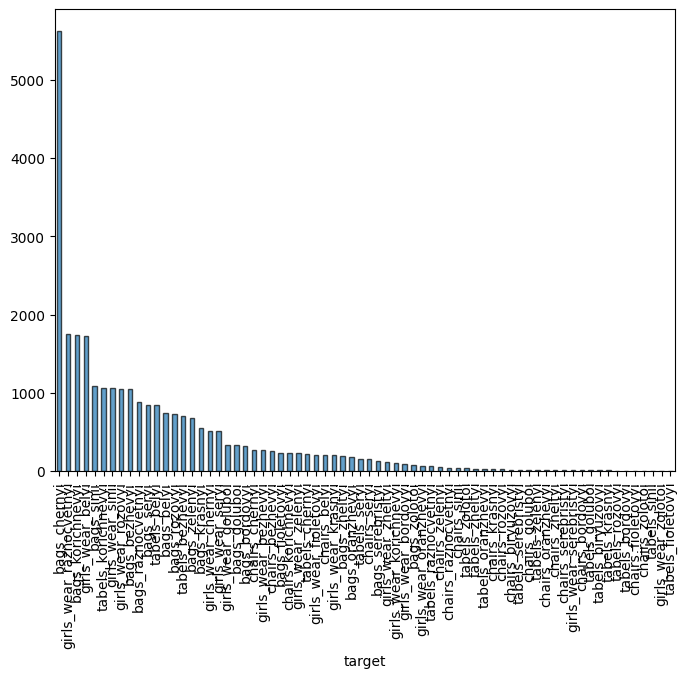

In [45]:
plt.figure(figsize=(8, 6))
train_val_files['target'].value_counts().plot(kind='bar', edgecolor='black', alpha=0.7)

In [46]:
len(train_val_files['target'].unique())

70

## Создадим новые датасеты.

Как мы можем видеть, 2 класса у нас пропали, скорее всего у нас нет в данных разноцветных столов и стульев. Это проблема возникла при добыче данных, следовательно решить мы ее сейчас не сможем. Учтем это на будущее.
=> количество классов = 70

In [47]:
train_val_labels = df['target']

# Делим выборку на train и val
from sklearn.model_selection import train_test_split
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

train_files = train_files.reset_index(drop=True)
val_files = val_files.reset_index(drop=True)

# Создадим объекты датасетов.
train_dataset = AvitoDataset(train_files, mode='train')
val_dataset = AvitoDataset(val_files, mode='val')

# Сравним размеры чтобы избежать ошибок.
print(f"Original len: train = {len(train_files)}, val = {len(val_files)}")
print(f"Dataset len: train = {train_dataset.len}, val = {val_dataset.len}")

Original len: train = 21227, val = 7076
Dataset len: train = 21227, val = 7076


In [48]:
# Сделаем weight sampleing
from torch.utils.data import WeightedRandomSampler

MIN_SIZE = 150 # минимальный размер примера

# Получаем веса для каждого примера
sample_weights = train_dataset.get_sample_weights(MIN_SIZE)

# Получаем веса классов
class_weights = train_dataset.get_class_weights(MIN_SIZE)

# Создаём семплер
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # Сколько примеров выбирать за эпоху
    replacement=True  # Обязательно для миноритарных классов!
)

In [49]:
# # Получаем список label_ids, которые будут сэмплиться
# sampled_label_ids = [train_dataset[index][1] for index in sampler]

# # Преобразуем в имена классов
# sampled_labels = train_dataset.label_encoder.inverse_transform(sampled_label_ids)

# # Рисуем гистограмму
# plt.figure(figsize=(12, 4))
# plt.hist(sampled_labels, bins=len(train_dataset.class_counts), edgecolor='black')
# plt.xticks(rotation=90)
# plt.title("Sampled Class Distribution (after WeightedRandomSampler)")
# plt.tight_layout()
# plt.show()

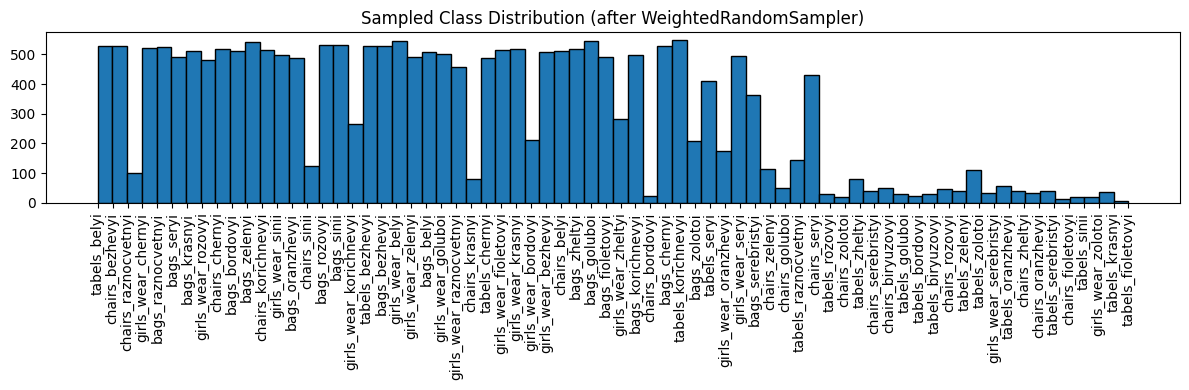

# Обучение модели ResNet34.

In [67]:
import torchvision.models as models
model_resnet = models.resnet34(pretrained=True).to(DEVICE)

c:\Users\vds\Work\Programming Stuff\hack\avito2\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
# Посмотрим на структуру модели
# model_resnet

In [68]:
class fc_layers(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.out = nn.Linear(256, 70)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        logits = self.out(x)
        return logits
    
model_resnet.fc = fc_layers()

Разморозим препоследний слой.

In [69]:
for param in model_resnet.parameters():
    param.requires_grad = False

model_resnet.layer4.requires_grad_(True)
model_resnet.fc.requires_grad_(True)

fc_layers(
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (out): Linear(in_features=256, out_features=70, bias=True)
)

Обучим 10 эпох. Проверим точность.

In [ ]:
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

In [ ]:
history, last_trained_model = train(train_loader, val_loader, model_resnet, optimizer, criterion, epochs=10)

Epochs:  10%|█         | 1/10 [08:49<1:19:21, 529.06s/it]

Val F1: 0.5664 (saved)
Epoch 1/10 | Train: loss 0.4632 acc 0.8618 f1 0.8692 | Val: loss 0.9019 acc 0.7425 f1 0.5664


Epochs:  20%|██        | 2/10 [18:13<1:13:21, 550.13s/it]

Epoch 2/10 | Train: loss 0.3763 acc 0.8841 f1 0.8899 | Val: loss 0.9820 acc 0.7284 f1 0.5477


Epochs:  30%|███       | 3/10 [27:32<1:04:39, 554.16s/it]

Epoch 3/10 | Train: loss 0.3263 acc 0.8963 f1 0.9009 | Val: loss 1.0057 acc 0.7251 f1 0.5205


Epochs:  40%|████      | 4/10 [36:52<55:38, 556.34s/it]  

Val F1: 0.5869 (saved)
Epoch 4/10 | Train: loss 0.2845 acc 0.9117 f1 0.9169 | Val: loss 0.9375 acc 0.7287 f1 0.5869


Epochs:  50%|█████     | 5/10 [46:15<46:34, 558.81s/it]

Epoch 5/10 | Train: loss 0.2668 acc 0.9158 f1 0.9209 | Val: loss 1.0507 acc 0.7239 f1 0.5480


Epochs:  60%|██████    | 6/10 [55:36<37:17, 559.43s/it]

Epoch 6/10 | Train: loss 0.2279 acc 0.9268 f1 0.9317 | Val: loss 1.0711 acc 0.7131 f1 0.5273


Epochs:  70%|███████   | 7/10 [1:04:43<27:46, 555.39s/it]

Epoch 7/10 | Train: loss 0.2136 acc 0.9344 f1 0.9385 | Val: loss 1.1235 acc 0.7171 f1 0.5463


Epochs:  70%|███████   | 7/10 [1:06:08<28:20, 566.94s/it]


KeyboardInterrupt: 

In [64]:
def load_resnet_34_model():
    model_resnet = models.resnet34(pretrained=False).to(DEVICE)

    class fc_layers(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc = nn.Sequential(
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Dropout(0.3)
            )

            self.out = nn.Linear(256, 70)

        def forward(self, x):
            x = x.view(x.size(0), -1)
            x = self.fc(x)

            logits = self.out(x)
            return logits
    
    
    model_resnet.fc = fc_layers()
    model_resnet = model_resnet.to(DEVICE)

    checkpoint = torch.load("checkpoints/best_model.pt", map_location=DEVICE)
    model_resnet.load_state_dict(checkpoint["model_state_dict"])
    return model_resnet

resnet_model = load_resnet_34_model()

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var". 
	size mismatch for fc.out.weight: copying a param with shape torch.Size([18, 256]) from checkpoint, the shape in current model is torch.Size([70, 256]).
	size mismatch for fc.out.bias: copying a param with shape torch.Size([18]) from checkpoint, the shape in current model is torch.Size([70]).